# Logistic regression example

We use Logistic Regression to calculate the probability for a student to pass an exam given the number of hours of study and number of hours slept:

$$p(\text{passed}) = \sigma(w_0 + w_1 \cdot \text{hours studied} + w_2 \cdot \text{hours slept})$$

### Initialize

In [52]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import optimize # for fit
%matplotlib inline
rng = np.random.RandomState(0)

## Read data

We first start to read a `cvs` file containing, for each student, the number of hours studied and slept (=the `features`) and the result (=the `labels`) of the exam: 0 (Failed) or 1 (passed).


   Studied      Slept   Passed
[[0.     0.     0.    ]
 [7.4517 1.0466 0.    ]
 [4.5133 0.8208 0.    ]
 [7.1874 8.4608 1.    ]
 [0.     6.8263 0.    ]
 [0.379  4.039  0.    ]
 [9.7729 6.9286 1.    ]
 [6.5881 0.1785 1.    ]
 [2.5981 3.0238 0.    ]
 [3.9293 2.9235 1.    ]]
(1000, 3)


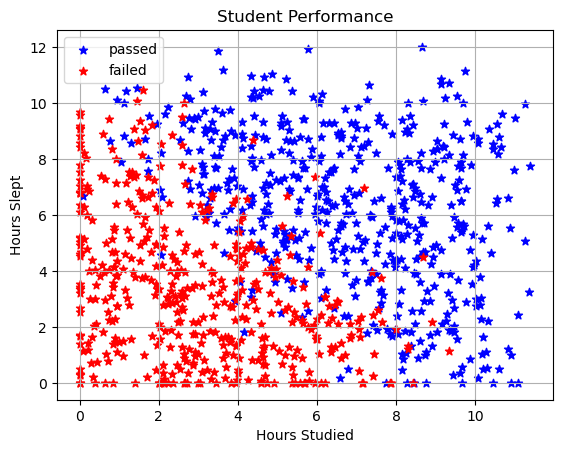

In [53]:
# Load and read file

from numpy import genfromtxt
my_data = genfromtxt('./data_student_exams.csv', delimiter=',')  # load data from 
print('%10s %10s %8s'% ('Studied', 'Slept', 'Passed'))


# Print first 10 entries

print(my_data[:10,:])
print(my_data.shape)


#  Separate the sample in student that passed the exam and that failed the exam

labels = my_data[:,2]
student_passed = my_data[my_data[:,2] == 1]
student_failed = my_data[my_data[:,2] == 0]


# Show on a figure for each student the number of hours slept as a function of the number of hours studied

#plt.figure(figsize=(12,7))
plt.title("Student Performance")
plt.scatter( student_passed[:,0], student_passed[:,1], marker = "*", c = "blue", label = "passed")
plt.scatter( student_failed[:,0], student_failed[:,1], marker = "*", c = "red", label = "failed" )
plt.xlabel("Hours Studied")
plt.ylabel("Hours Slept")
plt.legend()
plt.grid()

plt.savefig("scatter_studied_vs_slept.png", dpi = 300)


## Separate data in train and test sample



In [54]:
# Add a cololumn of 1 to Data features: (Bias term)

features = my_data[:,0:2]
bias = np.ones(shape=(len(features),1))
features = np.append(bias, features, axis=1)  #  [1, studied, slept] 
print(features)


# Separate features and labels into 500 entries each for training and testing 

N=500  # N examples for train and test
features_train = features[:N,:]
labels_train = labels[:N]
features_test = features[N:2*N,:]
labels_test = labels[N:2*N]

[[1.     0.     0.    ]
 [1.     7.4517 1.0466]
 [1.     4.5133 0.8208]
 ...
 [1.     6.9964 3.6712]
 [1.     2.1223 5.5283]
 [1.     6.7884 6.3987]]


## Sigmoid function

For training the Logistic Regression we'll need the sigmoid function `sigmoid(x)` and its derivative `dsig(x)` that returns, respectively $\sigma(x)$ and $\frac{\text{d} \sigma}{\text{d} x}(x)$.


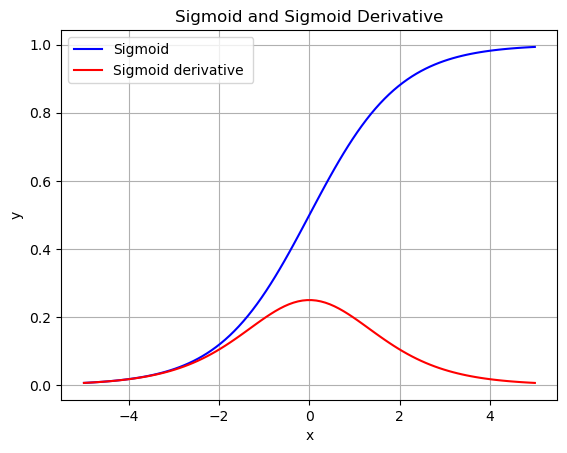

In [55]:
# Write two functions sigmoid and derivatide

def sigmoid(x):
    '''
    Returns sigmoid function
    '''
    result = 1/(1+np.exp(-x))
    return result

def dsig(x):
    '''
    Returns sigmoid derivative function
    '''
    result2 = sigmoid(x) * (1 - sigmoid(x))
    return result2


# Plotting the functions

z = np.linspace(-5,5,100)
#plt.figure(figsize=(12,7))
plt.title("Sigmoid and Sigmoid Derivative")
plt.plot(z, sigmoid(z), c = "blue", label = "Sigmoid")
plt.plot(z, dsig(z), c = "red", label = "Sigmoid derivative ")
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

plt.savefig("sigmoid_and_derivative.png", dpi = 300)

## Building a predictive model

The predictive model for a feature ${\bf x}$ is given by the function:

$$f({\bf x}) = \sigma \left( w_0 + \sum_{i=1}^D w_i x_i \right) = \sigma \left(\sum_{i=0}^D w_i x^*_i \right)$$

The cost function used in the Logistic Regression is the cross-entropy:

$$E({\bf w}) = - \frac{1}{N}\sum_{j=1}^N t_j \log( f({\bf x_j})) + (1-t_j) \log( 1 - f({\bf x_j}))$$

The gradient of the cross-entropy function is:
$$
\vec{\nabla} E({\bf w}) = \frac{1}{N}\sum_{j=1}^N \left[ f({\bf x_j}) - t_j \right] {\bf x^*_j} \rightarrow
\begin{cases}
\frac{\partial E({\bf w})}{\partial w_0} = \frac{1}{N}\sum_{j=1}^N \left[ f({\bf x_j}) - t_j \right] \\\\
\frac{\partial E({\bf w})}{\partial w_1} = \frac{1}{N}\sum_{j=1}^N \left[ f({\bf x_j}) - t_j \right] x_{j1} \\
\vdots \\
\frac{\partial E({\bf w})}{\partial w_D} = \frac{1}{N}\sum_{j=1}^N \left[ f({\bf x_j}) - t_j \right] x_{jD}
\end{cases}$$

### Functions needed for training

Let's define the functions needed to train the algorithm.


In [56]:
def predict(features, weights):
    '''
    Returns 1D array of probabilities
    that the class label == 1
    '''
    z = np.dot(features, weights)
    return sigmoid(z)

def cost_function(features, labels, weights):
    '''
    Cross-Entropy cost function

    Features:(1000,3)
    Labels: (1000,1)
    Weights:(3,1)
    Returns 1D matrix of predictions
    Cost = sum ( labels*log(predictions) + (1-labels)*log(1-predictions) ) / len(labels)
    '''
    observations = len(labels)

    predictions = predict(features, weights)

    #Take the error when label=1
    class1_cost = -labels*np.log(predictions)

    #Take the error when label=0
    class2_cost = (1-labels)*np.log(1-predictions)

    #Take the sum of both costs
    cost = class1_cost - class2_cost

    #Take the average cost
    cost = cost.sum()/observations

    return cost

def update_weights(features, labels, weights, lr):
    '''
    Gradient Descent

    Features:(100, 3)
    Labels: (100, 1)
    Weights:(3, 1)
    '''
    N = len(features)

    #1 - Get Predictions
    predictions = predict(features, weights)

    #2 Transpose features from (100, 3) to (3, 100)
    # So we can multiply w the (100,1)  cost matrix.
    # Returns a (3,1) matrix holding 3 partial derivatives --
    # one for each feature -- representing the aggregate
    # slope of the cost function across all observations
    gradient = np.dot(features.T,  predictions - labels)
    
    #3 Take the average cost derivative for each feature
    gradient /= N

    #4 - Multiply the gradient by our learning rate
    gradient *= lr
    
    #5 - Subtract from our weights to minimize cost
    weights -= gradient

    return weights

def train(features, labels, weights, lr, iters):
    """
    Training using gradient descent
    """
    cost_history = []

    for i in range(iters):
        weights = update_weights(features, labels, weights, lr)

        #Calculate error for auditing purposes
        cost = cost_function(features, labels, weights)
        cost_history.append(cost)

        # Log Progress
        if i % 1000 == 0:
            print("iter: "+str(i) + " cost: "+str(cost))

    return weights, cost_history

## Training

Calculate the weights with gradient descent for 20000 steps. Plot cost function evolution.

iter: 0 cost: 0.6044532685795113
iter: 1000 cost: 0.24384647197850512
iter: 2000 cost: 0.21029678637932336
iter: 3000 cost: 0.19762355078523455
iter: 4000 cost: 0.1911065848060038
iter: 5000 cost: 0.18723779681196784
iter: 6000 cost: 0.18474021519179978
iter: 7000 cost: 0.18303658396043573
iter: 8000 cost: 0.18182842749503522
iter: 9000 cost: 0.18094653271749087
iter: 10000 cost: 0.18028830693089032
iter: 11000 cost: 0.1797882873321365
iter: 12000 cost: 0.17940299183701228
iter: 13000 cost: 0.17910258994247705
iter: 14000 cost: 0.17886606692590612
iter: 15000 cost: 0.17867828795728766
iter: 16000 cost: 0.17852814792836258
iter: 17000 cost: 0.17840736804999335
iter: 18000 cost: 0.17830969162069754
iter: 19000 cost: 0.1782303337928339


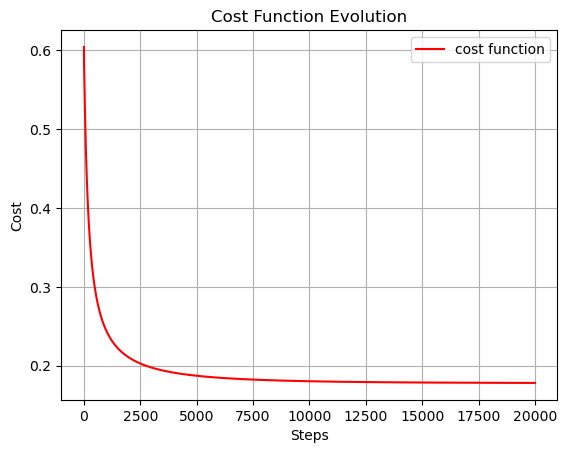

In [57]:
# Initialize weights

weights = np.array([0.0,0.0,0.0])


# Calculate weights with gradient descent

Niter=20000
learning_speed = 0.1  # learning rate


# Calculating the weights (TRAINING)

trained_weights, cost_history =  train(features_train, labels_train, weights, learning_speed, Niter)


# Plotting the cost_function

#plt.figure(figsize=(11,7))
plt.title("Cost Function Evolution")
plt.plot(range(len(cost_history)), cost_history, c = "r", label = "cost function")
plt.xlabel("Steps")
plt.ylabel("Cost")
plt.legend()
plt.grid()

plt.savefig("cost_function_evolution.png", dpi = 300)

## Accuracy of predictions

In [58]:
#  Determine the predicted probabilities for the training dataset

print(f"The optimized weights are: b = {trained_weights[0]:.2f}, w1 = {trained_weights[1]:.2f} , w2 = {trained_weights[2]:.2f}" ) # optimized weights
predicted_probabilities_train = predict(features_train, trained_weights)
predicted_labels_train = np.round(predicted_probabilities_train)   # Deduce the predicted labels (0 or 1).


# Calculate how correct predictions are 

def accuracy(predicted_labels, true_labels):
    '''
    Function to measure the correctness of predictions
    comparing the predicted labels to true labels and 
    divide by the total number of lables.
    '''
    matched = (np.abs(true_labels - predicted_labels)).sum()
    return 1- matched/len(true_labels)
accuracy_train = accuracy(predicted_labels_train, labels_train)
print("The accuracy for taining dataset is: %.3f" % accuracy_train)


# Determine the predicted probabilities and how correct predictions are w/ Test dataset

predicted_probabilities_test = predict(features_test, trained_weights)
predicted_labels_test = np.round(predicted_probabilities_test)
accuracy_test = accuracy(predicted_labels_test, labels_test)
print("The accuracy for test dataser is: %.3f" % accuracy_test)

The optimized weights are: b = -12.65, w1 = 1.49 , w2 = 1.22
The accuracy for taining dataset is: 0.924
The accuracy for test dataser is: 0.890


## Show results (with probabilities)

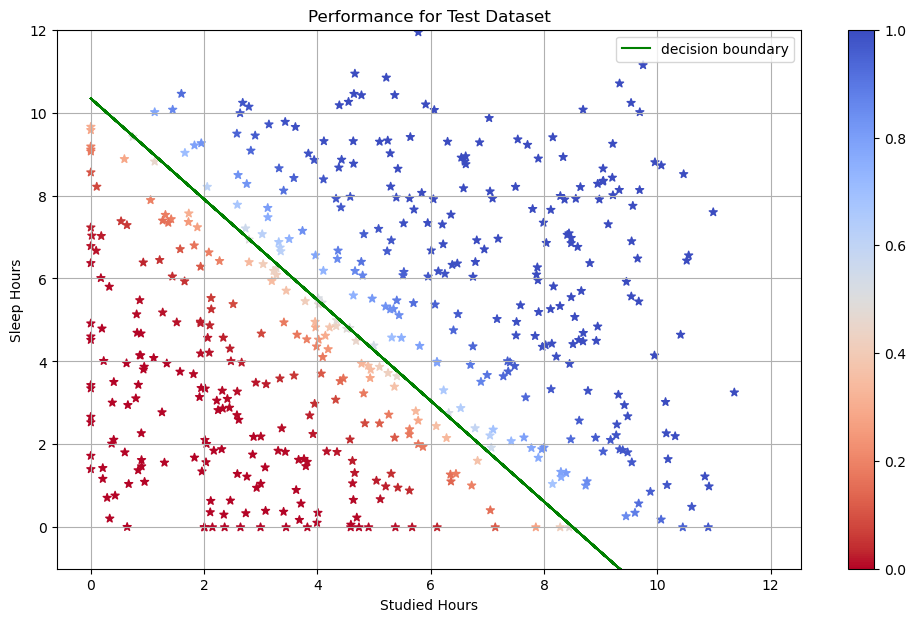

In [59]:
# Add a line showing the decision boundary separing both classes

sleep_hours = - (trained_weights[0] + trained_weights[1]*features_test[:,2])/ trained_weights[2]  # can be found by setting the weighted sum of inputs to 0 


# Show for each student the number of hours slept as a function of the number of hours studied

plt.figure(figsize=(12,7))
plt.title("Performance for Test Dataset")
plt.scatter(features_test[:,1], features_test[:,2], c = predicted_probabilities_test, marker = "*", cmap = "coolwarm_r", vmin = 0, vmax = 1)
plt.plot(features_test[:,2],sleep_hours, color = "g", label = "decision boundary" )
plt.ylim(-1, 12)
plt.xlabel("Studied Hours")
plt.ylabel("Sleep Hours")
plt.colorbar()
plt.grid()
plt.legend()


plt.savefig("decision_boundary_test.png", dpi = 300)



## Predicted probability distributions


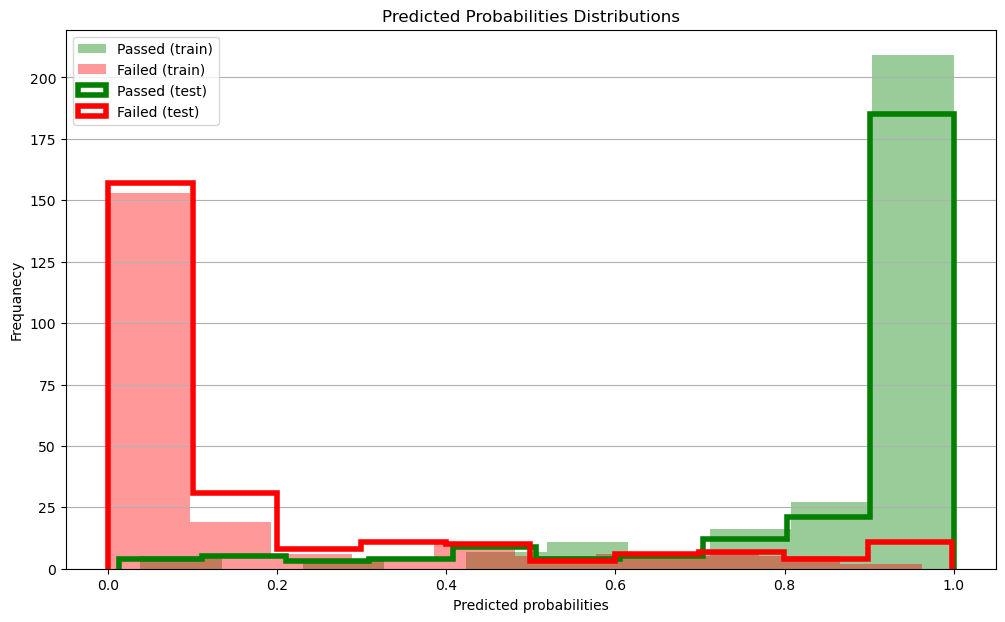

In [60]:
# Show the distribution of predicted probabilities for student that passed or failed, for both train and test dataset

plt.figure(figsize= (12,7))
plt.title("Predicted Probabilities Distributions")
plt.hist(predicted_probabilities_train[labels_train>=0.5], label = "Passed (train)", color = "green", alpha=0.4)
plt.hist(predicted_probabilities_train[labels_train<0.5], label = "Failed (train)", color = "red", alpha=0.4)
plt.hist(predicted_probabilities_test[labels_test>=0.5], label = "Passed (test)", color = "green", histtype='step',lw=4)
plt.hist(predicted_probabilities_test[labels_test<0.5], label = "Failed (test)", color = "red", histtype='step',lw=4)
plt.xlabel('Predicted probabilities')
plt.ylabel("Frequanecy")
plt.legend()
plt.grid(axis = "y")

plt.savefig("predicted_probabilities_test_train.png", dpi = 300)

## Confusion matrix

The `threshold` value corresponds to the probability threshold over which student are labelled as Passing the exam. Changing the threshold value we can see how the values in the confusion matrix change.

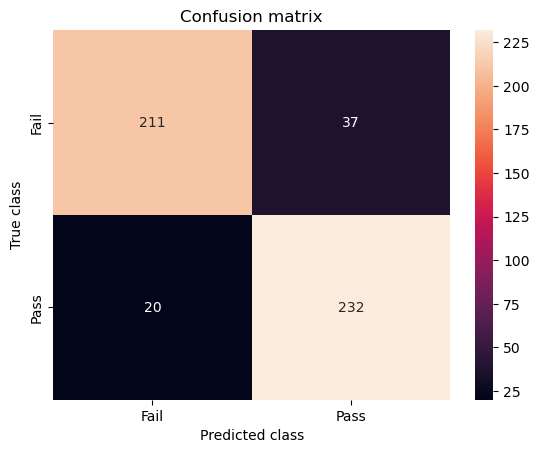

False positive rate = 14.92 %
True positive rate = 92.06 %


<Figure size 640x480 with 0 Axes>

In [61]:
# Libraries for confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns


# Define labels and threshold 

LABELS = ["Fail","Pass"]
threshold = 0.45   # threshold value


# Prediction

y_pred = [1 if e > threshold else 0 for e in predicted_probabilities_test]
conf_matrix = confusion_matrix(labels_test, y_pred)


# Confusion matrix

#plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
plt.savefig("confussion_matrix.png", dpi = 300)


# Scores
TN = conf_matrix[0,0] # True Negative (Fail -> Fail)
FP = conf_matrix[0,1] # False Positive (Fail -> Pass)
FN = conf_matrix[1,0] # False Negative (Pass -> Fail)
TP = conf_matrix[1,1] # True Positive (Pass -> Pass)
print('False positive rate = %.2f %%' % (FP/(FP+TN)*100))
print('True positive rate = %.2f %%' % (TP/(TP+FN)*100))

## ROC Curve

A more global way to assess the performance of the algorithm is to construct the ROC curve ("Receiver Operating Characteristic"). The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

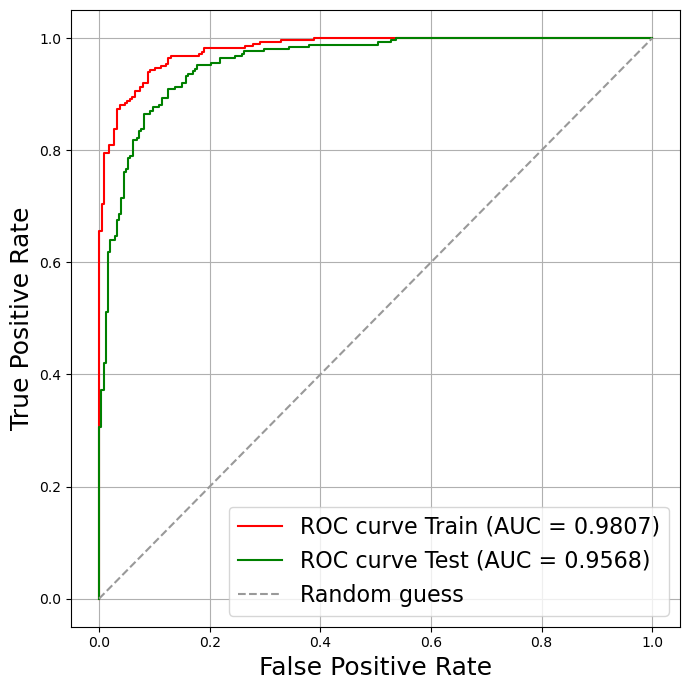

In [62]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict

#target = np.concatenate((np.zeros(x_train.shape[0]),np.ones(x_test.shape[0])))
#scores = np.concatenate((norm_train,norm_test))  

plt.figure(figsize=(7, 7))
# Train set                   
fp, vp, thresholds = roc_curve(labels_train,predicted_probabilities_train,pos_label=1,drop_intermediate=False)
roc_auc = auc(fp, vp)
plt.plot(fp,vp,color='red',label='ROC curve Train (AUC = %0.4f)'%(roc_auc))
# Test set                   
fp, vp, thresholds = roc_curve(labels_test,predicted_probabilities_test,pos_label=1,drop_intermediate=False)
roc_auc = auc(fp, vp)
plt.plot(fp,vp,color='green',label='ROC curve Test (AUC = %0.4f)'%(roc_auc))

plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.plot([0, 1],[0, 1],linestyle='--',color=(0.6, 0.6, 0.6),label='Random guess')
plt.grid()
plt.legend(loc="best",fontsize=16)
plt.tight_layout()
plt.savefig("ROC.png", dpi = 300)